In [136]:
import numpy as np
import h5py
import pandas as pd
import torch
import torch.nn as nn   

In [137]:
# === Scientific Reports figure style ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update({
    "font.family":     "Helvetica",   # Sci Rep: single sans-serif family
    "font.size":        8,            # 8 pt everywhere after reduction
    "axes.labelsize":   8,
    "axes.titlesize":   8,
    "xtick.labelsize":  8,
    "ytick.labelsize":  8,
    "legend.fontsize":  8,
    "lines.linewidth":  0.6,          # ≥0.5 pt after final sizing
    "figure.dpi":       300,
})
sns.set_theme(context="paper", style="ticks", rc=mpl.rcParams)


In [138]:
class MLP(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(h_dim, h_dim//2)
        self.dp2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(h_dim//2, out_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dp1(x)
        x = torch.relu(self.fc2(x))
        x = self.dp2(x)
        x = self.fc3(x)
        return x

In [45]:
#read spike in model
model = MLP(128,32,3)

#model_path
model_path = '/mnt/deepstore/Final_DeepPhenotyping/pipeline/model_weights/spikein_model_04_30.pth'
model.load_state_dict(torch.load(model_path))
model.eval()



MLP(
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (dp1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)

In [139]:
from sklearn.neighbors import KDTree

def assign_labels(features1, features2, radius=2.0):
    """
    Assign labels to features1 from features2 where
    1) frame_id matches and
    2) distance between (x, y) <= radius.
    
    Returns an updated copy of features1 with a 'label' column.
    """
    # Ensure we have a 'label' column in features1, set default 0
    if 'label' not in features1.columns:
        features1['label'] = 0
    
    # Convert to avoid SettingWithCopyWarnings:
    features1 = features1.copy()
    features2 = features2.copy()
    
    # We will store subsets of features1 in a dictionary keyed by frame_id
    grouped_f1 = dict(tuple(features1.groupby('frame_id')))
    # Also group features2 by frame_id
    grouped_f2 = dict(tuple(features2.groupby('frame_id')))
    
    # For efficient column access:
    label_col_idx = features1.columns.get_loc('label')
    
    # We'll also store updated subsets in a dictionary
    updated_subsets = {}
    
    # Iterate only over frame_ids that are in features1
    for fid, subset_f1 in grouped_f1.items():
        # Build a KDTree for the (x, y) coords in features1 for this frame
        coords_f1 = subset_f1[['x', 'y']].values
        if len(coords_f1) > 0:
            kdtree = KDTree(coords_f1)
        else:
            updated_subsets[fid] = subset_f1
            continue
        
        # If this frame_id also exists in features2, we do the radius queries
        if fid in grouped_f2:
            subset_f2 = grouped_f2[fid]
            coords_f2 = subset_f2[['x', 'y']].values
            
            # Use query_radius to find neighbors within the given radius
            neighbor_indices_array = kdtree.query_radius(coords_f2, r=radius)
            
            # Convert subset_f1 to numpy for assignment, then we will put it back in a DataFrame
            subset_f1_values = subset_f1.values
            
            # Assign label for each set of neighbor indices
            for i, indices in enumerate(neighbor_indices_array):
                if len(indices) > 0:
                    lbl = subset_f2.iloc[i]['label']
                    subset_f1_values[indices, label_col_idx] = lbl
            
            # Re-wrap in a dataframe
            subset_f1_updated = pd.DataFrame(subset_f1_values, 
                                             columns=subset_f1.columns,
                                             index=subset_f1.index)
        else:
            # No labels to assign if there's no corresponding frame in features2
            subset_f1_updated = subset_f1
        
        updated_subsets[fid] = subset_f1_updated
    
    # Concatenate all updated subsets back together
    updated_features1 = pd.concat(updated_subsets.values(), axis=0)
    
    return updated_features1

In [140]:
#read data file

#train:0B87711, 0B68720

#test: /mnt/deepstore/PRISM/pipeline/data/spike_prism

#read each file in test/{slide}/{slide}.hdf5

import os

data_path = '/mnt/deepstore/Final_DeepPhenotyping/pipeline/output/spike_0428'
annotated_path = '/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/annotated_slides'
slides = os.listdir(data_path)
slides = [s for s in slides if os.path.isdir(os.path.join(data_path, s))]


#make a dictionary to store the results for each slide
results = {}


for slide in slides: 

    print(f'Processing {slide}')

    #skip train slides: #train:0B87711, 0B68720
    if slide in ['0B87711', '0B68720','0B68520','0B8B306','0B60114']:
        continue

    features1 = pd.read_parquet(os.path.join(data_path, slide, f'{slide}.parquet.gz'))
    features2 = pd.read_hdf(os.path.join(annotated_path, slide, f'{slide}.hdf5'), key='features')

    features1 = assign_labels(features1, features2, radius=3.0)

    #features1 contains the features, 'label' contains the labels
    del features2 #free memory

    #run the model on features1 columns 'z0' to 'z127' and store the output in 'prediction'

    features1 = features1.dropna()
    features1 = features1.reset_index(drop=True)

    #keep only features 'z0' to 'z127', search by column name
    features = features1.loc[:, 'z0':'z127'].values

    #scale the features using the scaler
    #features = scaler.transform(features)

    #convert to torch tensor
    features = torch.tensor(features, dtype=torch.float32)

    #this is 2.5 million rows, so we need to run the model in batches
    batch_size = 20000
    predictions = []

    for i in range(0, features.shape[0], batch_size):
        batch = features[i:i+batch_size]
        prediction = model(batch)
        predictions.append(prediction)


    #apply max to get the class with the highest probability
    predictions = torch.cat(predictions, dim=0)
    probabilities = torch.softmax(predictions, dim=1)
    probabilities = probabilities.detach().numpy()
    predictions = torch.argmax(predictions, dim=1)
    predictions = predictions.detach().numpy()

    #store the predictions in the 'prediction' column of features1
    features1['prediction'] = predictions

    #add probabilities to the features1 dataframe in columns 'prob0', 'prob1', 'prob2'
    features1['prob0'] = probabilities[:, 0]
    features1['prob1'] = probabilities[:, 1]
    features1['prob2'] = probabilities[:, 2]

    #calculate classwise precision, recall, f1 score based on labels and predictions

    precision = []
    recall = []
    f1 = []
    skbr3_support = 0
    hpaec_support = 0

    for label in range(3):
        true_positive = ((features1['label'] == label) & (features1['prediction'] == label)).sum()
        false_positive = ((features1['label'] != label) & (features1['prediction'] == label)).sum()
        false_negative = ((features1['label'] == label) & (features1['prediction'] != label)).sum()

        if true_positive == 0:
            precision.append(0)
            recall.append(0)
            f1.append(0)
        else:
            precision.append(true_positive / (true_positive + false_positive))
            recall.append(true_positive / (true_positive + false_negative))
            f1.append(2 * precision[-1] * recall[-1] / (precision[-1] + recall[-1]))
        
        if label == 1:
            #support is the number of true events with label 1
            skbr3_support = true_positive + false_negative
        if label == 2:
            #support is the number of true events with label 2
            hpaec_support = true_positive + false_negative


    print(f'{slide}: precision={precision}, recall={recall}, f1={f1}')

    #store the results in the dictionary
    results[slide] = {'precision': precision, 'recall': recall, 'f1': f1, 'features': features1, 
                      'skbr3_support': skbr3_support, 'hpaec_support': hpaec_support}







Processing 0B68620
0B68620: precision=[0.9999958215441185, 0.8867521367521367, 0], recall=[0.9999677671017909, 0.9834123222748815, 0], f1=[0.999981794126188, 0.9325842696629213, 0]
Processing 0B60414
0B60414: precision=[0.999989169063553, 0.913953488372093, 0.9213483146067416], recall=[0.9999748725866853, 0.9899244332493703, 0.9213483146067416], f1=[0.9999820207740209, 0.9504232164449818, 0.9213483146067416]
Processing 0B87816
0B87816: precision=[0.9999848403931623, 0, 0.996551724137931], recall=[0.9999995668619974, 0, 0.8919753086419753], f1=[0.9999922035733622, 0, 0.9413680781758959]
Processing 0B87911
0B87911: precision=[0.9999915303347746, 0.9029535864978903, 0.9821428571428571], recall=[0.9999893014993503, 0.981651376146789, 0.873015873015873], f1=[0.9999904159158205, 0.9406593406593406, 0.9243697478991596]
Processing 0B68720
Processing 0B8B306
Processing 0B68520
Processing 0B60214
0B60214: precision=[0.9999932755902666, 0.9175911251980983, 0], recall=[0.999972682648018, 0.9731092

In [141]:
#combine all slide features and draw overall precision-recall curve
all_features = pd.concat([result['features'] for result in results.values()], axis=0)

In [142]:
labels = ['Others', 'SK-BR-3', 'HPAEC']
colors = ['cornflowerblue', 'dodgerblue','orange']


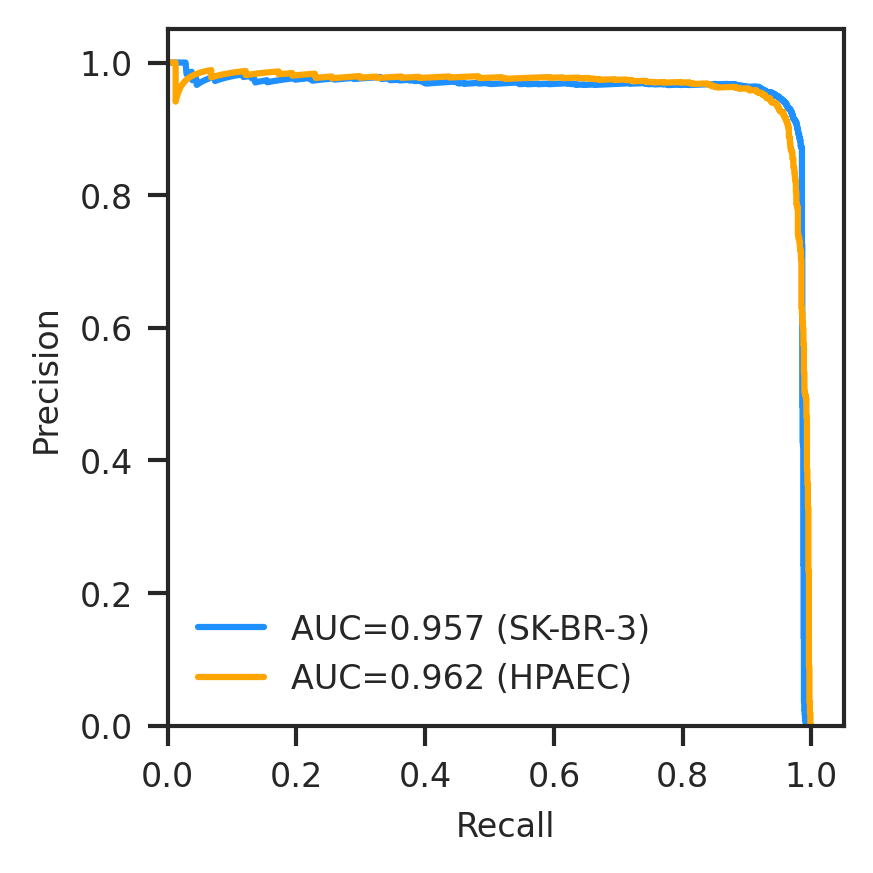

In [161]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(3,3))
for label in range(3):
    if label == 0:  
        continue
    precision, recall, _ = precision_recall_curve(all_features['label'] == label, all_features[f'prob{label}'])
    #area under the curve
    ap = auc(recall, precision)
    #plot the precision-recall curve
    plt.plot(recall, precision, label=f'AUC={ap:.3f} ({labels[label]})', color=colors[label], lw=1.5)

plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=8)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=8)
plt.legend(frameon=False, loc='lower left', fontsize=8)
plt.tight_layout()
plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/precision_recall_curve.pdf', dpi=600, bbox_inches='tight')
plt.show()



In [145]:
#save the all_features dataframe to a parquet file
all_features.to_parquet('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/all_features.parquet.gz')

In [146]:
#create a copy of all_features where all rows with label 0 and prediction 0 are removed
all_features_filtered = all_features[(all_features['label'] != 0) | (all_features['prediction'] != 0)]

print(f'Filtered features: {len(all_features_filtered)}')

#save the filtered features to a parquet file
all_features_filtered.to_parquet('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/predictions.parquet.gz', index=False)

Filtered features: 3480


In [147]:
#read all_features_filtered from the parquet file
all_features_filtered = pd.read_parquet('/mnt/deepstore/PRISM/figures/F6_spike_in/predictions_noTN.parquet.gz')

In [56]:
features = all_features_filtered.loc[:, 'z0':'z127']

In [57]:
#run UMAP
import umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding = reducer.fit_transform(features)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


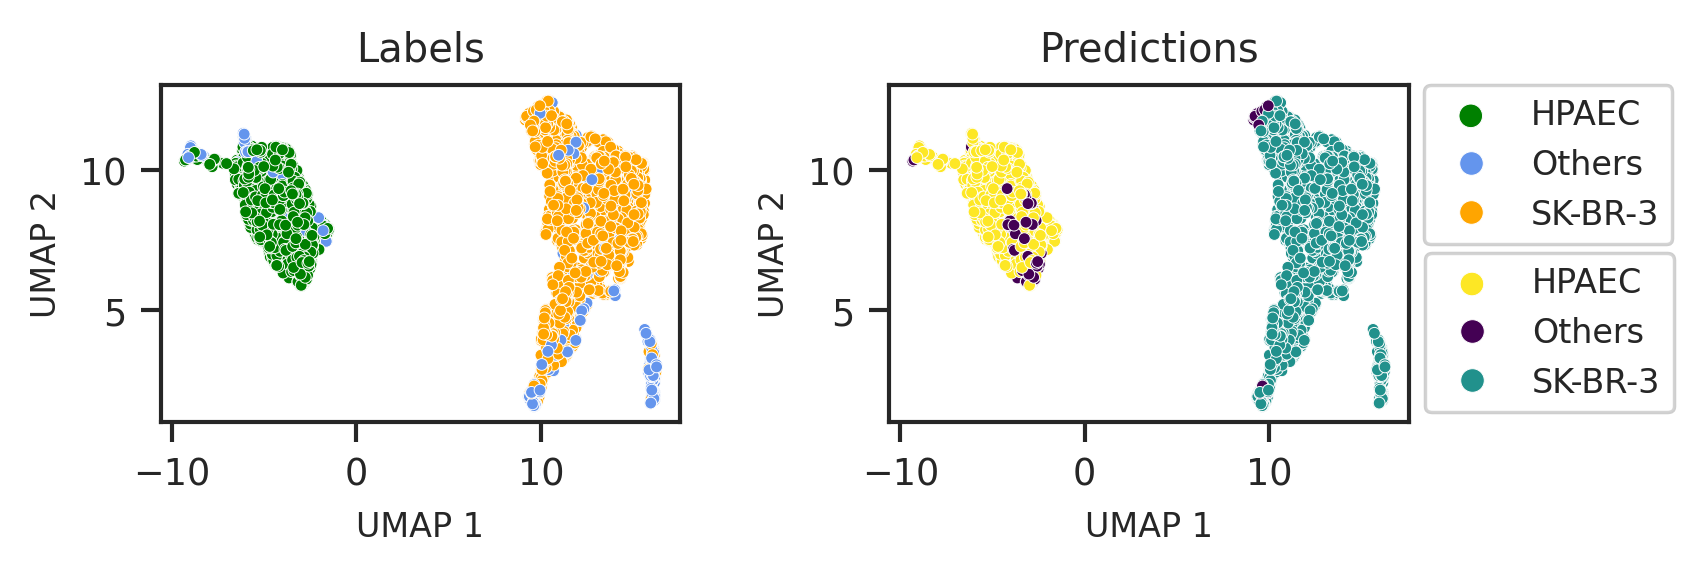

In [87]:
plt.figure(figsize=(5, 2))

#####################
# Subplot 1: color by label
#####################
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=all_features_filtered['label'].astype(int),
    palette=colors,
    s=8,
    ax=ax1
)
ax1.set_title('Labels')

# Legend for subplot 1 (place it on the right, near the top)
leg1 = ax1.legend(
    loc='upper left',          # anchor the upper-left corner of the legend
    bbox_to_anchor=(2.4, 1.05),  # (x=1.35 means to the right; y=1 is top alignment)
    fontsize=8,
    markerscale=2,
    labels=['HPAEC', 'Others', 'SK-BR-3']
)


#####################
# Subplot 2: color by prediction
#####################
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=all_features_filtered['prediction'],
    palette="viridis",
    s=8,
    ax=ax2
)
ax2.set_title('Predictions')

# Legend for subplot 2 (stack it below the first legend)
leg2 = ax2.legend(
    loc='upper left',
    bbox_to_anchor=(1.0, 0.55),  # same x as above, but lower y
    fontsize=8,
    markerscale=2,
    labels=['HPAEC', 'Others', 'SK-BR-3']
)

# Set shared x axis and y axis labels
ax1.set_xlabel('UMAP 1', fontsize=8)
ax1.set_ylabel('UMAP 2', fontsize=8)
ax2.set_xlabel('UMAP 1', fontsize=8)
ax2.set_ylabel('UMAP 2', fontsize=8)

# Make sure legend stays on this subplot
ax1.add_artist(leg1)

# Make sure legend stays on this subplot
ax2.add_artist(leg2)

# Use tight_layout so subplots don't overlap
plt.tight_layout()
plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/umap.pdf', dpi=600, bbox_inches='tight')
plt.show()


In [154]:
#print results
for slide, result in results.items():
    print(f'{slide}: precision={result["precision"]}, recall={result["recall"]}, f1={result["f1"]}')

0B68620: precision=[0.9999958215441185, 0.8867521367521367, 0], recall=[0.9999677671017909, 0.9834123222748815, 0], f1=[0.999981794126188, 0.9325842696629213, 0]
0B60414: precision=[0.999989169063553, 0.913953488372093, 0.9213483146067416], recall=[0.9999748725866853, 0.9899244332493703, 0.9213483146067416], f1=[0.9999820207740209, 0.9504232164449818, 0.9213483146067416]
0B87816: precision=[0.9999848403931623, 0, 0.996551724137931], recall=[0.9999995668619974, 0, 0.8919753086419753], f1=[0.9999922035733622, 0, 0.9413680781758959]
0B87911: precision=[0.9999915303347746, 0.9029535864978903, 0.9821428571428571], recall=[0.9999893014993503, 0.981651376146789, 0.873015873015873], f1=[0.9999904159158205, 0.9406593406593406, 0.9243697478991596]
0B60214: precision=[0.9999932755902666, 0.9175911251980983, 0], recall=[0.999972682648018, 0.973109243697479, 0], f1=[0.9999829790131232, 0.9445350734094617, 0]
0B60314: precision=[0.9999866989674852, 0, 0.9755434782608695], recall=[0.9999942361758002,

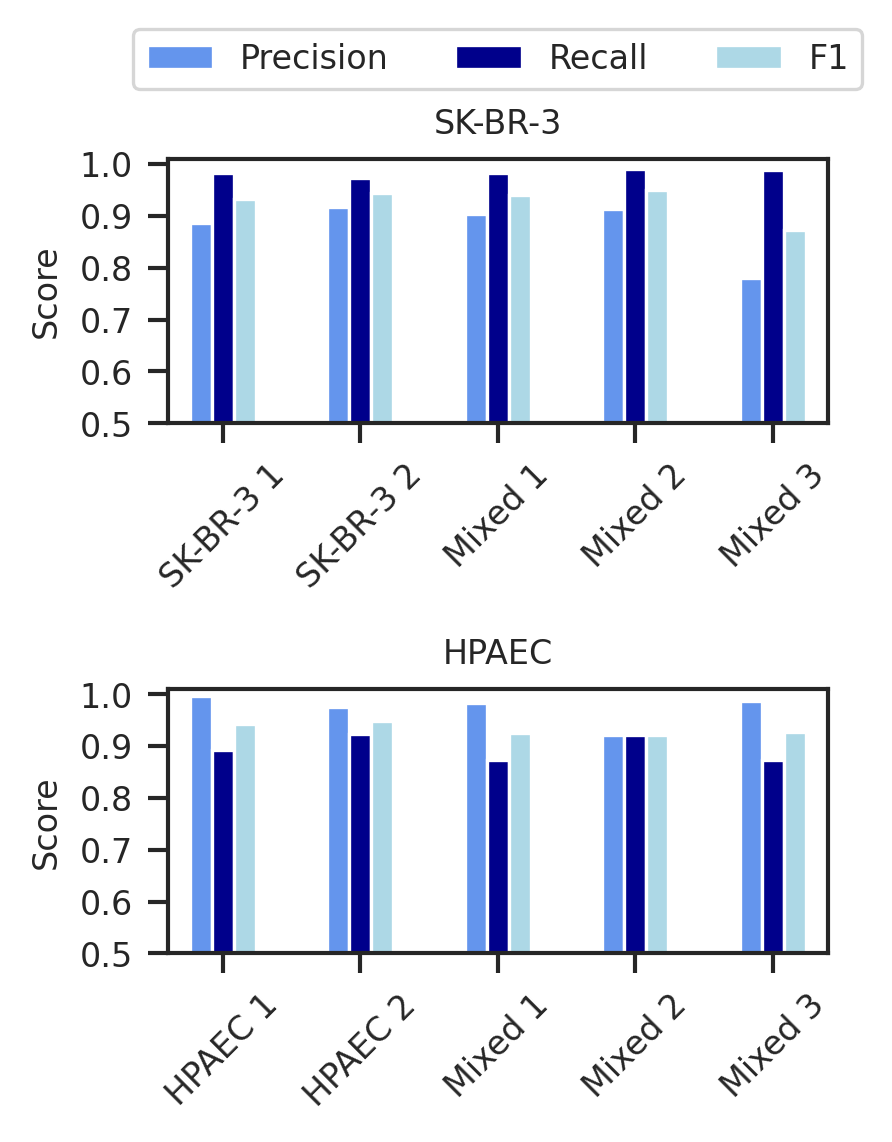

In [ ]:
#plot classwise precision, recall, and f1-score for SK-BR-3 and HPAEC. 

#slides with SK-BR-3 and HPAEC
#SK-BR-3: 0B68620, 0B60214
#HPAEC: 0B87816, 0B60314
#Double Spike-in (contains both SK-BR-3 and HPAEC): 0B87911, 0B60414, 0B68820

slides = ['0B68620', '0B60214', '0B87816', '0B60314', '0B87911', '0B60414', '0B68820']
sk_br_3_slides = ['0B68620', '0B60214', '0B87911', '0B60414', '0B68820']
hpaec_slides = ['0B87816', '0B60314', '0B87911', '0B60414', '0B68820']

#store the results for SK-BR-3 and HPAEC in separate dictionaries
sk_br_3_results = {}
hpaec_results = {}

for slide in slides:
    if slide in sk_br_3_slides:
        sk_br_3_results[slide] = results[slide]
    if slide in hpaec_slides:
        hpaec_results[slide] = results[slide]


sk_br_3_slides = list(sk_br_3_results.keys())
hpaec_slides = list(hpaec_results.keys())

sk_br_3_precision = np.array([result['precision'] for result in sk_br_3_results.values()])  # shape (n_slides, 3)
#get only the precision for SK-BR-3, which is the second class
sk_br_3_precision = sk_br_3_precision[:, 1]

#same for recall and f1
sk_br_3_recall = np.array([result['recall'] for result in sk_br_3_results.values()])
sk_br_3_recall = sk_br_3_recall[:, 1]

sk_br_3_f1 = np.array([result['f1'] for result in sk_br_3_results.values()])
sk_br_3_f1 = sk_br_3_f1[:, 1]

hpaec_precision = np.array([result['precision'] for result in hpaec_results.values()])
hpaec_precision = hpaec_precision[:, 2]

hpaec_recall = np.array([result['recall'] for result in hpaec_results.values()])
hpaec_recall = hpaec_recall[:, 2]

hpaec_f1 = np.array([result['f1'] for result in hpaec_results.values()])
hpaec_f1 = hpaec_f1[:, 2]

#replace slide names with more descriptive names, SK-BR-3 1, SK-BR-3 2, SK-BR-3, Double Spike-in 1, Double Spike-in 2, HPAEC 1, HPAEC 2, HPAEC 3
sk_br_3_slides = ['SK-BR-3 1', 'SK-BR-3 2', 'Mixed 1', 'Mixed 2', 'Mixed 3']
hpaec_slides = ['HPAEC 1', 'HPAEC 2', 'Mixed 1', 'Mixed 2', 'Mixed 3']

x_centres = np.linspace(0, 5, num=5)


#plot sk-br-3 precision, recall, f1 in grouped bar plots, where each slide is on the x-axis
plt.figure(figsize=(3, 4))
plt.subplot(2, 1, 1)
plt.xlim(-0.5, 5.5)
plt.bar(x_centres - 0.2, sk_br_3_precision, width=0.2, label='Precision', color='cornflowerblue')
plt.bar(x_centres + 0.0, sk_br_3_recall, width=0.2, label='Recall', color='darkblue')
plt.bar(x_centres + 0.2, sk_br_3_f1, width=0.2, label='F1', color='lightblue')
plt.xticks(x_centres, sk_br_3_slides, rotation=45, fontsize=8, ha='center')
plt.ylabel('Score', fontsize=8)
plt.title('SK-BR-3', fontsize=8)
plt.ylim(0.5, 1.01)
plt.yticks(np.arange(0.5, 1.001, 0.1), fontsize=8)
plt.legend(frameon=True, loc='lower center', fontsize=8,ncol=3, bbox_to_anchor=(0.5, 1.2))
#plt.legend(frameon=False, loc='upper right', fontsize=9, bbox_to_anchor=(-0.7,1))

plt.subplot(2, 1, 2)
plt.xlim(-0.5, 5.5)
plt.bar(x_centres - 0.2, hpaec_precision, width=0.2, label='Precision', color='cornflowerblue')
plt.bar(x_centres + 0.0, hpaec_recall, width=0.2, label='Recall', color='darkblue')
plt.bar(x_centres + 0.2, hpaec_f1, width=0.2, label='F1', color='lightblue')
plt.xticks(x_centres, hpaec_slides, rotation=45, fontsize=8, ha='center')
plt.ylabel('Score', fontsize=8)
plt.title('HPAEC', fontsize=8)
plt.ylim(0.5, 1.01)
plt.yticks(np.arange(0.5, 1.001, 0.1), fontsize=8)
#lt.legend(frameon=False, loc='upper right', fontsize=9, bbox_to_anchor=(-0.7,1))

plt.tight_layout()


plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/perslide.pdf', dpi=600, bbox_inches=None)
plt.show()

In [156]:
sk_br_3_results.keys()

dict_keys(['0B68620', '0B60214', '0B87911', '0B60414', '0B68820'])

In [159]:
sk_br_3_support = np.array([result['skbr3_support'] for result in sk_br_3_results.values()])
hpaec_support = np.array([result['hpaec_support'] for result in hpaec_results.values()])

In [158]:
sk_br_3_support

array([422, 595, 218, 397, 270])

In [160]:
#save the metrics to a csv file, one for SK-BR-3 and one for HPAEC
sk_br_3_metrics = pd.DataFrame({
    'slide': sk_br_3_slides,
    'precision': sk_br_3_precision,
    'recall': sk_br_3_recall,
    'f1': sk_br_3_f1,
    'support': sk_br_3_support
})
hpaec_metrics = pd.DataFrame({
    'slide': hpaec_slides,
    'precision': hpaec_precision,
    'recall': hpaec_recall,
    'f1': hpaec_f1,
    'support': hpaec_support
})
sk_br_3_metrics.to_csv('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/sk_br_3_metrics.csv', index=False)
hpaec_metrics.to_csv('/mnt/deepstore/Final_DeepPhenotyping/figures/figure6_spikein/hpaec_metrics.csv', index=False)

In [64]:
#calculate overall precision, recall, f1-score for the three classes
overall_precision = []
overall_recall = []
overall_f1 = []

for label in range(3):
    true_positive = ((all_features['label'] == label) & (all_features['prediction'] == label)).sum()
    false_positive = ((all_features['label'] != label) & (all_features['prediction'] == label)).sum()
    false_negative = ((all_features['label'] == label) & (all_features['prediction'] != label)).sum()

    if true_positive == 0:
        overall_precision.append(0)
        overall_recall.append(0)
        overall_f1.append(0)
    else:
        overall_precision.append(true_positive / (true_positive + false_positive))
        overall_recall.append(true_positive / (true_positive + false_negative))
        overall_f1.append(2 * overall_precision[-1] * overall_recall[-1] / (overall_precision[-1] + overall_recall[-1]))

print(f'Overall: precision={overall_precision}, recall={overall_recall}, f1={overall_f1}')



Overall: precision=[0.9999897329327877, 0.884469696969697, 0.959504132231405], recall=[0.9999810255853087, 0.982124079915878, 0.9027993779160186], f1=[0.9999853792400935, 0.9307424015944197, 0.9302884615384615]


In [65]:
#print average or net precision and recall for only classes 1 and 2

#average precision and recall for classes 1 and 2
average_precision = (overall_precision[1] + overall_precision[2]) / 2
average_recall = (overall_recall[1] + overall_recall[2]) / 2
average_f1 = (overall_f1[1] + overall_f1[2]) / 2
print(f'Average: precision={average_precision}, recall={average_recall}, f1={average_f1}')


Average: precision=0.921986914600551, recall=0.9424617289159483, f1=0.9305154315664406
